## (3) Mean Passengers per Weekday per Hour

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plot
data = pd.read_csv("../datasets/Ruter_data.csv", delimiter=';')
data.shape

(6000, 17)

In [3]:
# We grab the needed data
pad = data[['Dato', 'Tidspunkt_Faktisk_Avgang_Holdeplass_Fra', 'Passasjerer_Ombord']]

Departure time is non-existant for some entries, we need to remove them before continuing.

In [4]:
pad = pad[data.Tidspunkt_Faktisk_Avgang_Holdeplass_Fra != ':']
pad.reset_index(inplace=True, drop=True)
pad

,Dato,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Passasjerer_Ombord
0,10/08/2020,10:53:59,5
1,15/08/2020,13:12:26,5
2,03/08/2020,10:19:21,6
3,27/07/2020,13:52:26,10
4,27/08/2020,07:34:53,10
...,...,...,...
5994,10/06/2020,16:23:48,2
5995,23/06/2020,06:00:40,2
5996,11/06/2020,17:43:10,3
5997,13/08/2020,06:00:23,5


Further more, time could be given in a format exceeding 24 hours, we need to correct that to be able to use pandas datetime library.

Ex: **01/01/2020 25:00:00** -> **02/01/2020 01:00:00**

In [5]:
# Helper function
def get_hour(time) : return int(time[0:2])

# We insert a new column containing the hour, here we keep the original 24h+ time format for later use
pad.insert(3, 'Hour', [get_hour(pad['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'][i]) for i in range(len(pad))], True)
pad

,Dato,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Passasjerer_Ombord,Hour
0,10/08/2020,10:53:59,5,10
1,15/08/2020,13:12:26,5,13
2,03/08/2020,10:19:21,6,10
3,27/07/2020,13:52:26,10,13
4,27/08/2020,07:34:53,10,7
...,...,...,...,...
5994,10/06/2020,16:23:48,2,16
5995,23/06/2020,06:00:40,2,6
5996,11/06/2020,17:43:10,3,17
5997,13/08/2020,06:00:23,5,6


In [6]:
# Helper functions for formatting date correctly, and fixing time
def format_date(date) : 
    d, m, y = map(int, date.split('/'))
    return pd.Timestamp(day=d, month=m, year=y)

def actual_date(hour, date) :
    if hour > 23:
        act_date = format_date(date) + pd.Timedelta('1 days')
        act_hour = hour % 24
    else:
        act_date = format_date(date)
        act_hour = hour
        
    return (act_date, act_hour)
   

# temporary storage of dates and hours in regular 24 hour time
actual_time = {'Dato' : [], 'Hour' : []}

# Iterate through all entries, 
for i in range(len(pad)) :
    d, h = actual_date(pad['Hour'][i], pad['Dato'][i])
    actual_time['Dato'].append(d)
    actual_time['Hour'].append(h)
    
# We replace the entire date column with these newly calculated dates
# We do the same for the hour column
pad = pad.assign(Dato=actual_time['Dato'])
pad = pad.assign(Hour=actual_time['Hour'])

# When inserting the day of week, we need to be careful and get our data from the temporary storage
pad.insert(4, 'Day_of_Week', [actual_time['Dato'][i].dayofweek for i in range(len(pad))], True)
df = pad[['Day_of_Week', 'Hour', 'Passasjerer_Ombord']]
df

,Day_of_Week,Hour,Passasjerer_Ombord
0,0,10,5
1,5,13,5
2,0,10,6
3,0,13,10
4,3,7,10
...,...,...,...
5994,2,16,2
5995,1,6,2
5996,3,17,3
5997,3,6,5


Now that we have our data ready, lets look for some outliers

In [7]:
df.Passasjerer_Ombord.describe()

count    5999.000000
mean        4.509918
std         6.732506
min       -39.000000
25%         0.000000
50%         3.000000
75%         7.000000
max        64.000000
Name: Passasjerer_Ombord, dtype: float64

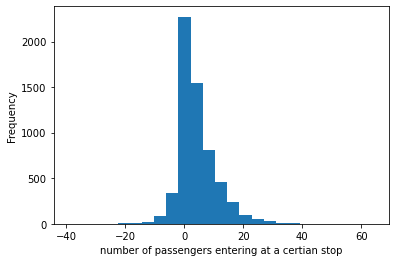

In [8]:
plot.hist(df.Passasjerer_Ombord, bins=25)
plot.xlabel('number of passengers entering at a certian stop')
plot.ylabel('Frequency')
plot.show()

Although we have som data as low as negative forty and as high as sixty, we see the overwhelming majority of entries lies between -20 and 40. Lets focus on that data.

In [9]:
lower, upper = df.Passasjerer_Ombord.quantile([0.0035, 0.99])
lower, upper

(-15.0, 28.0)

Cutting out the bottom 0.35 and the top 1 percentile seems to do just that

Text(0, 0.5, 'Frequency')

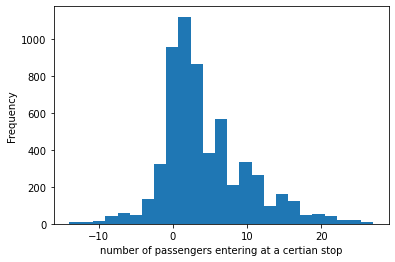

In [10]:
# Removing data under lower and above upper bound
cut_df = df[(df.Passasjerer_Ombord > lower) & (df.Passasjerer_Ombord < upper)]
plot.hist(cut_df.Passasjerer_Ombord, bins=25)
plot.xlabel('number of passengers entering at a certian stop')
plot.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

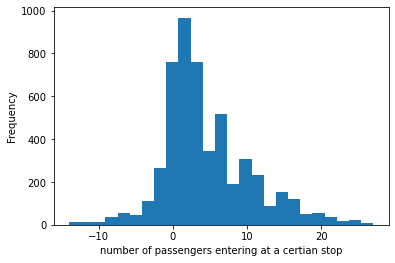

In [11]:
# Removing data other than hours 06 - 21
workh_df = cut_df[(cut_df.Hour >= 6) & (cut_df.Hour <= 21)]
plot.hist(workh_df.Passasjerer_Ombord, bins=25)
plot.xlabel('number of passengers entering at a certian stop')
plot.ylabel('Frequency')

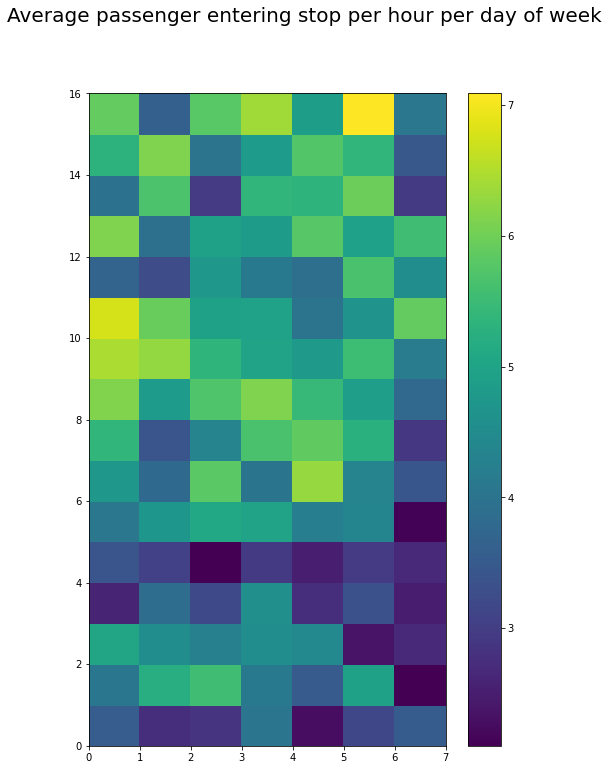

In [51]:
workh_df.reset_index(inplace=True, drop=True)

# Create empty data structure
calender = [[[] for x in range(7)] for y in range(16)]

# Lets take the passenger data and plot it acccoring to time of day and day of week
for i in range(len(workh_df)) :
    hour = workh_df['Hour'][i]
    day = workh_df['Day_of_Week'][i]
    calender[hour - 6][day].append(workh_df['Passasjerer_Ombord'][i])
    
for y in range(16) :
    for x in range(7) :
        s = calender[y][x]
        if len(s) >= 1 : # take avrage
            calender[y][x] = np.mean(s)
        else:            # ingore
            calender[y][x] = 0
            

ax = plot.subplot()
ax.set_title('Average passenger entering stop per hour per day of week')
p = ax.pcolormesh(calender)
plot.plot()
plot.ylabel('Hour')
plot.xlabel('Weekday')
fig, ax = plot.subplots(figsize=(8, 12))
ax = plot.pcolormesh(calender)
fig.colorbar(c)
fig.show()